In [49]:
import warnings
warnings.filterwarnings("ignore")

from geopy.geocoders import Nominatim
from shapely.geometry import LineString
import geopandas as gpd
from networkx.algorithms import approximation as approx

import networkx as nx
import osmnx as ox
import matplotlib.pyplot as plt
import contextily as ctx

In [9]:
# define a custom filter for open street map to get the streets
CUSTOM_FILTER = (
    '["highway"]["area"!~"yes"]["highway"!~"bridleway|bus_guideway|bus_stop|construction|cycleway|elevator|footway|'
    'motorway|motorway_junction|motorway_link|escalator|proposed|construction|platform|raceway|rest_area|'
    'path|service"]["access"!~"customers|no|private"]["public_transport"!~"platform"]'
    '["fee"!~"yes"]["foot"!~"no"]["service"!~"drive-through|driveway|parking_aisle"]["toll"!~"yes"]'
)

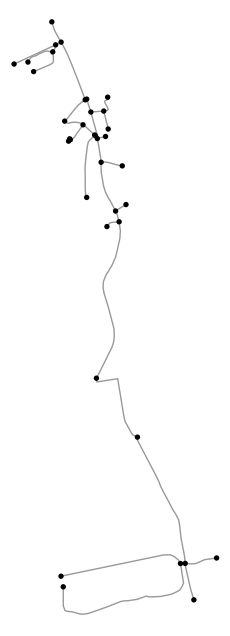

In [15]:
location = "Ecton, United Kingdom"
org_graph = ox.graph_from_place(location, custom_filter=CUSTOM_FILTER)

# Simplifying the original directed multi-graph to undirected, so we can go both ways in one way streets
graph = ox.utils_graph.get_undirected(org_graph)
fig, ax = ox.plot_graph(graph, node_zorder=2, node_color="k", bgcolor="w")

In [ ]:
# get CRS of graph

In [19]:
# geocoder function
def geocode_address(address):
    geolocator = Nominatim(user_agent='originGetter')
    location = geolocator.geocode(address)
    return location.longitude, location.latitude if location else 0



In [92]:
# define origin and destination addresses
origin_address = '4 Barton Fields, Ecton, United Kingdom'
destination_address = '4 Barton Fields, Ecton, United Kingdom'
# geocode origin address
origin_loc = geocode_address(origin_address)
if origin_loc == 0: 
    print('Origin address not found')
else: 
    print(f'Origin coordinates are: {origin_loc}')
# geocode destination address
destination_loc = geocode_address(destination_address)
if destination_loc == 0:
    print('Destination address not found')
else:
    print(f'Destination coordinates are: {destination_loc}')

# get origin node ID based on coordinates
origin_ID = ox.distance.nearest_nodes(graph, origin_loc[0], origin_loc[1], return_dist=False)

# define destination node ID based on coordinates
dest_ID = ox.distance.nearest_nodes(graph, destination_loc[0], destination_loc[1], return_dist=False)

# convert graph to be undirected
G = ox.utils_graph.get_undirected(graph)

# Convert multigraph to a simple graph
H = nx.Graph()
for u, v, data in G.edges(data=True):
    w = data.get('length', 1)  # Assuming 'length' is the edge weight; default to 1 if not available
    if H.has_edge(u, v):
        H[u][v]['weight'] = min(H[u][v]['weight'], w)  # Keep the minimum weight
    else:
        H.add_edge(u, v, weight=w)


# check for a eulerian circuit
if nx.is_eulerian(H):
    circuit = list(nx.eulerian_circuit(G, source=origin_ID))
else:
    print("Graph is not Eulerian; needs modifications to become Eulerian.")



Origin coordinates are: (52.2622889, -0.7875529)
Destination coordinates are: (52.2622889, -0.7875529)
Graph is not Eulerian; needs modifications to become Eulerian.


In [93]:
def remove_odd_degree_nodes(G):
    # Identify nodes with odd degree
    odd_degree_nodes = [node for node, degree in G.degree() if degree % 2 != 0]
    # Remove nodes with odd degrees
    G.remove_nodes_from(odd_degree_nodes)
    return odd_degree_nodes

def insert_nodes_into_path(G, path, nodes_to_insert):
    new_path = path.copy()
    for node in nodes_to_insert:
        # Find the closest node in the current path
        neighbors = G.neighbors(node)
        # Find the closest neighbor that is in the path
        closest = min(neighbors, key=lambda x: new_path.index(x) if x in new_path else float('inf'))
        # Insert the node next to its closest neighbor in the new path
        idx = new_path.index(closest) + 1
        new_path.insert(idx, node)
        new_path.insert(idx + 1, closest)  # Re-insert the neighbor to simulate travel to and from the inserted node
    return new_path

 # Remove nodes with odd degree
removed_nodes = remove_odd_degree_nodes(H)
print("Graph after removing odd degree nodes:", H.edges())
print("Removed nodes:", removed_nodes)

 # Calculate Eulerian path if possible
if nx.is_eulerian(H):
    eulerian_path = list(nx.eulerian_path(G))
    eulerian_path = [node for node, _ in eulerian_path]
else:
    print("No Eulerian path available. Exiting...")

Graph after removing odd degree nodes: [(417586909, 1262138368), (1262138368, 1245962201)]
Removed nodes: [8078048, 4637850882, 570695788, 291981168, 291981933, 291981908, 1108333285, 1121875568, 291981910, 291981927, 291981928, 2516854935, 1108323220, 291981953, 359863685, 1121878203, 417586925, 570695920, 1121875565, 1108333213, 1121875564, 1121878215, 1245962197, 10712597747, 1245962213, 4637850881, 7841783337, 7841783339, 7841783344, 7841783353, 10712664025, 10712664024]
No Eulerian path available. Exiting...


In [84]:
# Check if the graph is Eulerian
if nx.is_eulerian(H):
    circuit = list(nx.eulerian_circuit(H))
    print("Eulerian Circuit Exists and here is the circuit:", circuit)
else:
    print("Graph is still not Eulerian.")
    # Optionally check which nodes still have odd degrees
    odd_degree_nodes_after = [node for node in H if H.degree(node) % 2 == 1]
    print("Nodes with odd degrees after matching:", odd_degree_nodes_after)

Graph is still not Eulerian.
Nodes with odd degrees after matching: [8078048, 4637850882, 570695788, 291981168, 291981933, 291981908, 1108333285, 1121875568, 291981910, 291981927, 291981928, 2516854935, 1108323220, 291981953, 359863685, 1121878203, 417586925, 570695920, 1121875565, 1108333213, 1121875564, 1121878215, 1245962197, 10712597747, 1245962213, 4637850881, 7841783337, 7841783339, 7841783344, 7841783353, 10712664025, 10712664024]


In [43]:
# Convert paths to LineString geometries
def path_to_linestring(path, graph):
    edge_nodes = zip(path[:-1], path[1:])
    lines = []
    for u, v in edge_nodes:
        if (u, v) in graph.edges:
            lines.append(graph.edges[u, v, 0]['geometry'])
        elif (v, u) in graph.edges:  # Handle undirected graphs
            lines.append(graph.edges[v, u, 0]['geometry'])
    return LineString([point for line in lines for point in line.coords])

# Create a dictionary of LineString objects from paths
path_geometries = {end_node: path_to_linestring(paths[end_node], graph) for end_node in paths}

# Convert to GeoDataFrame
geo_df = gpd.GeoDataFrame({
    'destination_node': path_geometries.keys(),
    'geometry': path_geometries.values()
}, crs="EPSG:4326")

print(geo_df.head())



   destination_node                                           geometry
0        1245962197                                   LINESTRING EMPTY
1        1245962201  LINESTRING (-0.78294 52.24737, -0.78293 52.247...
2       10712597747  LINESTRING (-0.78294 52.24737, -0.78293 52.247...
3        1262138368  LINESTRING (-0.78294 52.24737, -0.78293 52.247...
4        1245962213  LINESTRING (-0.78294 52.24737, -0.78293 52.247...


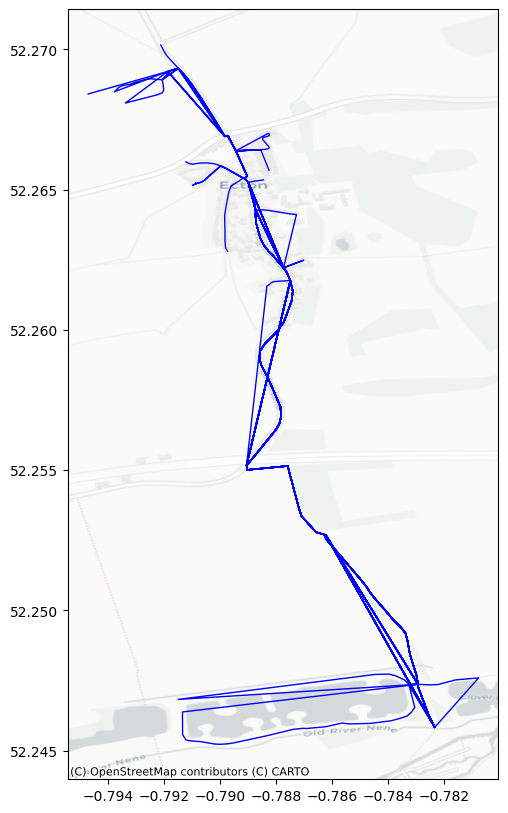

In [46]:
# visualize paths on a map
fig, ax = plt.subplots(figsize=(10, 10))
geo_df.plot(ax=ax, linewidth=1, edgecolor='blue')
ctx.add_basemap(ax, crs=geo_df.crs.to_string(), source=ctx.providers.CartoDB.Positron)
plt.show()

In [ ]:
# export paths